In [51]:
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
from numpy import array

C:\Users\Pablo\AppData\Local\Temp\ipykernel_14344\2646226964.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [52]:
import numpy as np
import matplotlib.dates as mdates


In [53]:
data = pd.read_csv('gold_data.csv')
data['Date'] = pd.to_datetime(data['Date'])
series = data.iloc[::-1].reset_index()['Close/Last'].tolist()
date =  data.iloc[::-1].reset_index()['Date']

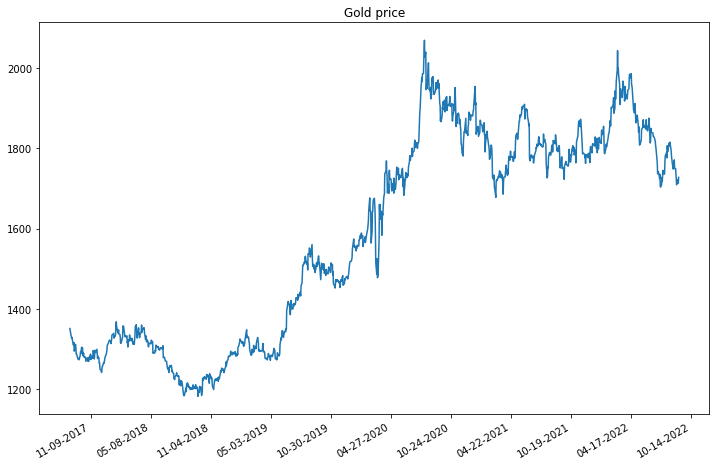

In [55]:
plt.figure(figsize=(12,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=180))
plt.plot(date,series)
plt.gcf().autofmt_xdate()
plt.title('Gold price')
plt.show()

## Functions

In [156]:
# trajectory matrix for solving supervized learning task
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # входящая последовательность (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # прогнозируемая последовательность (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# diffential series interval
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

 
# train / test splitting
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series
    diff_series = difference(raw_values, 1)
    #diff_series = raw_values
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test


# fit an LSTM network
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    
    # stateful = True - keep state in memory;
    
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        print(i)
        hist = model.fit(X, y, validation_split=0.1,epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    print(model.summary())
    return model,history_loss,history_val_loss
 
# 1 step of forecasting
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]
 
# Forecasting
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts, y
 
# обратная разность
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
 
# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

In [ ]:
# trajectory matrix for solving supervized learning task
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # входящая последовательность (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # прогнозируемая последовательность (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [109]:
scaler = MinMaxScaler(feature_range=(-1, 1))
itial_to_prepared = scaler.fit_transform(difference(series, 1).values.reshape(len(difference(series, 1)), 1))

In [172]:
n_lag = int(len(series)/5*2)
n_seq = int(len(series)/5)
n_test = 1
n_epochs = 30
n_batch = 1
n_neurons =  8

In [173]:
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

model,history_loss,history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

forecasts, test_real = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
test_real_inverted = inverse_transform(series, [test_real.tolist()], scaler, n_test+2)

0
453/453 [==============================] - 4s 3ms/step - loss: 0.0480 - val_loss: 0.0343
1
453/453 [==============================] - 1s 2ms/step - loss: 0.0473 - val_loss: 0.0344
2
453/453 [==============================] - 1s 2ms/step - loss: 0.0470 - val_loss: 0.0346
3
453/453 [==============================] - 1s 2ms/step - loss: 0.0465 - val_loss: 0.0350
4
453/453 [==============================] - 1s 2ms/step - loss: 0.0461 - val_loss: 0.0354
5
453/453 [==============================] - 1s 2ms/step - loss: 0.0456 - val_loss: 0.0358
6
453/453 [==============================] - 1s 2ms/step - loss: 0.0451 - val_loss: 0.0362
7
453/453 [==============================] - 1s 2ms/step - loss: 0.0448 - val_loss: 0.0368
8
453/453 [==============================] - 1s 2ms/step - loss: 0.0444 - val_loss: 0.0374
9
453/453 [==============================] - 1s 2ms/step - loss: 0.0443 - val_loss: 0.0375
10
453/453 [==============================] - 1s 2ms/step - loss: 0.0440 - val_loss: 0.037

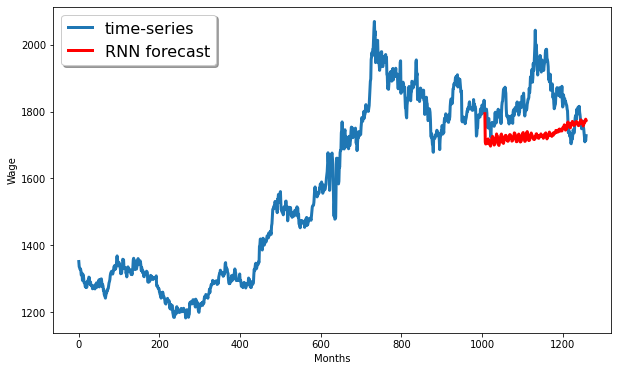

In [174]:
# visualize

fig=plt.figure(figsize=(10,6))
plt.plot(series[:],linewidth=3)
off_s = len(data) - n_test*n_seq  - 1 
off_e = off_s + len(forecasts[0]) + 1
xaxis = [x for x in range(off_s, off_e)]
yaxis = [series[off_s]] + forecasts[-1]
plt.plot(xaxis, yaxis, color='r',linewidth=3)

plt.ylabel('Wage')
plt.xlabel('Months')

plt.legend(('time-series', 'RNN forecast'),
           shadow=True, loc='upper left', handlelength=1.5, fontsize=16)
plt.show()

In [180]:
predicted = forecasts[0]
real = series[-n_seq:]